# Install and Import packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load and Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/geo/data/"
work_path = "/content/drive/MyDrive/geo/Route_Simulation/CVRP_Romeoville/"

In [ ]:
zips_to_drop = [60658, 46211, 46351, 86705, 46354, 61009, 60057, 60635, 60092, 60125, 46438]

In [ ]:
# # print dataframe.
# missing_zipcodes_df

zips = pd.read_csv(f"{data_path}/Romeoville/USZIPCodeToCityStateDB.csv")
zips = zips.rename(columns = {"Zip Code": "zipcode", "ZipLatitude":"latitude", "ZipLongitude":"longitude"})
zips = zips.drop_duplicates(subset = "zipcode",keep='first')
zips = zips.dropna()
zips = zips.drop(zips.index[zips["zipcode"].isin(zips_to_drop)]) # There is no zipcode in US as 46438
zips.to_csv(f"{data_path}/Romeoville/Romeoville_zips_no_missing_geo.csv")
zips
zips.head()

,zipcode,City,County,State,CountyFIPS,StateFIPS,TimeZone,DayLightSavings,latitude,longitude
0,501,HOLTSVILLE,SUFFOLK,NY,103,36,5,Y,40.815400,-73.045600
1,544,HOLTSVILLE,SUFFOLK,NY,103,36,5,Y,40.815400,-73.045600
2,601,ADJUNTAS,ADJUNTAS,PR,1,72,4,N,18.196747,-66.736735
3,602,AGUADA,AGUADA,PR,3,72,4,N,18.352927,-67.177532
4,603,RAMEY,AGUADILLA,PR,5,72,4,N,18.458585,-67.129867


In [ ]:
######################### Load Romeoville detailed data ############################
romeoville = pd.read_csv(f"{data_path}/Romeoville/zips_954_Volume.csv")
romeoville = romeoville.drop("Unnamed: 0", axis = 1)
romeoville.rename(columns = {"postal_code":"PostalCodeID"}, inplace = True)
romeoville = romeoville.drop(romeoville.index[romeoville["PostalCodeID"].isin(zips_to_drop)]) # There is no zipcode in US as 46438
romeoville.head()

,PostalCodeID,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,...,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,Volume
0,46001,US,Alexandria,Indiana,IN,Madison,95.0,NaN,NaN,40.2561,...,46001.0,B5,G6350,S,191227265.0,414880.0,40.251410,-85.658060,"POLYGON ((-85.77509099999999 40.291807, -85.77...",4970.38
1,46011,US,Anderson,Indiana,IN,Madison,95.0,NaN,NaN,40.1146,...,46011.0,B5,G6350,S,193593591.0,196587.0,40.130099,-85.760763,"POLYGON ((-85.86357799999999 40.132998, -85.86...",34467.83
2,46012,US,Anderson,Indiana,IN,Madison,95.0,NaN,NaN,40.1309,...,46012.0,B5,G6350,S,83995263.0,717985.0,40.154670,-85.619672,"POLYGON ((-85.68543199999999 40.119701, -85.68...",22099.36
3,46013,US,Anderson,Indiana,IN,Madison,95.0,NaN,NaN,40.0619,...,46013.0,B5,G6350,S,56007399.0,29609.0,40.047933,-85.681768,"POLYGON ((-85.73794099999999 40.013825, -85.73...",32609.45
4,46016,US,Anderson,Indiana,IN,Madison,95.0,NaN,NaN,40.0988,...,46016.0,B5,G6350,S,16488765.0,0.0,40.097817,-85.681513,"POLYGON ((-85.711325 40.110800000000005, -85.7...",9817.27


In [ ]:
zips_no_goe_data = list(set(romeoville["PostalCodeID"]) - set(zips["zipcode"]))
print("Number of missing zipcodes:",len(zips_no_goe_data))
print("Missing zipcodes:",zips_no_goe_data)

Number of missing zipcodes: 0
Missing zipcodes: []


In [ ]:
# data = [[60658,41.87555805014667, -85.64619944392109],
#         [46211, 42.648517950463045, -83.51171443903486], 
#         [46351, 42.15964393407559, -83.49169050090823],
#         [86705, 40.686468623433036, -86.1336579780562], 
#         [46354, 39.98751368607813, -86.00368463216023], 
#         [61009, 42.0639504900147, -86.02974711415389],
#         [60057, 39.94695770828473, -86.01019007400673],
#         [60635, 40.05386574815841, -86.01716201669646],
#         [60092, 39.95007094693943, -86.00794876051448],
#         [60125, 41.8219789383028, -85.78621946868519]]
        
# # Create the pandas DataFrame
# missing_dipcodes_df = pd.DataFrame(data, columns = ['zipcode', 'latitude', 'longitude'])

# zips = zips.append(missing_zipcodes_df)
# zips.reset_index(drop = True, inplace=True)

# zips_no_goe_data = list(set(romeoville["PostalCodeID"]) - set(zips["zipcode"]))
# print("Number of missing zipcodes:",len(zips_no_goe_data))
# print("Missing zipcodes:",zips_no_goe_data)


In [ ]:
vol_path = f"{data_path}/Romeoville/Romeoville_zipcodes_By_dates_Volume.csv"
sales_path = f"{data_path}/Romeoville/Romeoville_zipcodes_By_dates_Sales.csv"

In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    df.rename(columns = {"Unnamed: 0":"PostalCodeID"}, inplace = True)

    df.set_index("PostalCodeID", inplace=True)

    count = np.where(df != 0, 1, 0)
    count = pd. DataFrame(count, columns = df.columns, index = df.index)
    print(df)
    return df,count

In [ ]:
vol_df, vol_count_df = load_data(vol_path)
sales_df, sales_count_df =load_data(sales_path)


              2010-01-01  2010-01-02  2010-01-03  2010-01-04  2010-01-05  \
PostalCodeID                                                               
46001                0.0         0.0         0.0         0.0         0.0   
46011                0.0         0.0         0.0         0.0         0.0   
46012                0.0         0.0         0.0         0.0         0.0   
46013                0.0         0.0         0.0         0.0         0.0   
46016                0.0         0.0         0.0         0.0         0.0   
...                  ...         ...         ...         ...         ...   
62447                0.0         0.0         0.0         0.0         0.0   
62468                0.0         0.0         0.0         0.0         0.0   
62469                0.0         0.0         0.0         0.0         0.0   
62474                0.0         0.0         0.0         0.0         0.0   
86705                0.0         0.0         0.0         0.0         0.0   

           

In [ ]:
# vol_df = pd.read_csv(f"{data_path}/Romeoville/Romeoville_zipcodes_By_dates_Volume.csv")
# vol_df.rename(columns = {"Unnamed: 0":"PostalCodeID"}, inplace = True)

# vol_df.set_index("PostalCodeID", inplace=True)

# vol_count = np.where(vol_df != 0, 1, 0)
# vol_count_df= pd. DataFrame(vol_count, columns=vol_df.columns, index = vol_df.index)

# vol_df
# # vol_df.columns = vol_df.iloc[0].astype(int)
# # vol_df = vol_df.iloc[1:,:]


# sales_df = pd.read_csv()
# sales_df.rename(columns = {"Unnamed: 0":"PostalCodeID"}, inplace = True)

# sales_df.set_index("PostalCodeID", inplace=True)

# vol_count = np.where(sales_df != 0, 1, 0)
# sales_count_df = pd. DataFrame(vol_count, columns=sales_df.columns, index = sales_df.index)

# sales_df

# # sales_df = sales_df.T
# # sales_df.columns = sales_df.iloc[0].astype(int)
# # sales_df = sales_df.iloc[1:,:]

In [ ]:
# zipcode_vol = []
# zipcode_sales = []
# num_days_vol =[]
# sum_vol = []
# num_days_sales =[]
# sum_sales = []

# # Get the count of non-Zeros values in columns 
# for i in vol_df.columns:
# #     print(i)
#     count_vol = (vol_df[i] != 0).sum()
# #     print(count)
#     sum_v = vol_df[i].sum()
# #     print(sum_)
#     sum_vol.append(sum_v)
#     zipcode_vol.append(i)
#     num_days_vol.append(count_vol)

In [ ]:
# CONVERT DATA TO WEEKLY DATA
def new_case_count(state_new_cases):
    first_Monday_found = False
    week_case_count = 0
    week_case_counts = []
    for index, value in state_new_cases.items():
        index_date = pd.to_datetime(index, format='%Y/%m/%d', 
                                    exact = False)
        index_day_of_week = index_date.day_name()
        if not first_Monday_found and index_day_of_week != 'Monday':
            continue
        first_Monday_found = True
        week_case_count += value
        if index_day_of_week == 'Sunday':
            week_case_counts.append(week_case_count)
            week_case_count = 0
    return week_case_counts


# converting list to DataFrame object
vol_count_df_weekly = pd.DataFrame(new_case_count(vol_count_df))
sales_count_df_weekly = pd.DataFrame(new_case_count(sales_count_df))

vol_count_df_weekly.head(), sales_count_df_weekly.head()

(PostalCodeID  46001  46011  46012  46013  46016  46017  46018  46030  46031  \
 2010-01-04        0      0      0      0      0      0      0      0      0   
 2010-01-11        0      1      0      0      0      0      0      0      0   
 2010-01-18        1      0      0      0      0      0      0      0      0   
 2010-01-25        0      0      1      0      0      0      0      1      0   
 2010-02-01        0      0      0      1      0      0      0      0      0   
 
 PostalCodeID  46032  ...  62423  62428  62440  62441  62442  62447  62468  \
 2010-01-04        4  ...      0      0      0      0      0      0      0   
 2010-01-11        4  ...      0      0      0      0      0      0      0   
 2010-01-18        4  ...      0      0      0      1      0      0      0   
 2010-01-25        2  ...      0      0      0      0      0      0      0   
 2010-02-01        3  ...      0      0      0      0      0      0      0   
 
 PostalCodeID  62469  62474  86705  
 2010-01-04

In [ ]:
# converting list to DataFrame object
vol_df_weekly = pd.DataFrame(new_case_count(vol_df))
sales_df_weekly = pd.DataFrame(new_case_count(sales_df))

vol_df_weekly.head(), sales_df_weekly.head()

(PostalCodeID  46001  46011  46012  46013  46016  46017  46018  46030  46031  \
 2010-01-04     0.00   0.00   0.00   0.00    0.0    0.0    0.0   0.00    0.0   
 2010-01-11     0.00  64.18   0.00   0.00    0.0    0.0    0.0   0.00    0.0   
 2010-01-18    36.73   0.00   0.00   0.00    0.0    0.0    0.0   0.00    0.0   
 2010-01-25     0.00   0.00   8.97   0.00    0.0    0.0    0.0  92.05    0.0   
 2010-02-01     0.00   0.00   0.00  84.01    0.0    0.0    0.0   0.00    0.0   
 
 PostalCodeID   46032  ...  62423  62428  62440  62441  62442  62447  62468  \
 2010-01-04    296.75  ...    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
 2010-01-11    246.32  ...    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
 2010-01-18    307.71  ...    0.0    0.0    0.0  12.85    0.0    0.0    0.0   
 2010-01-25    131.11  ...    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
 2010-02-01    148.19  ...    0.0    0.0    0.0   0.00    0.0    0.0    0.0   
 
 PostalCodeID  62469  62474  86705  
 2010

In [ ]:
vol_df_weekly.to_csv(f"{data_path}/Romeoville/Romeoville_Weekly_Data_Volume.csv")
sales_df_weekly.to_csv(f"{data_path}/Romeoville/Romeoville_Weekly_Data_Sales.csv")

In [ ]:
vol_df_weekly = vol_df_weekly.reset_index()
vol_df_weekly = vol_df_weekly.rename(columns = {'index' : 'date'})
vol_df_weekly

PostalCodeID,date,46001,46011,46012,46013,46016,46017,46018,46030,46031,...,62423,62428,62440,62441,62442,62447,62468,62469,62474,86705
0,2010-01-04,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,2010-01-11,0.00,64.18,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,2010-01-18,36.73,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,12.85,0.0,0.00,0.0,0.0,0.0,0.0
3,2010-01-25,0.00,0.00,8.97,0.00,0.00,0.0,0.0,92.05,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,2010-02-01,0.00,0.00,0.00,84.01,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2022-02-21,0.00,129.20,128.88,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,119.00,167.0,0.00,0.0,0.0,0.0,0.0
634,2022-02-28,0.00,167.00,67.00,270.35,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,128.00,0.0,13.91,0.0,0.0,0.0,0.0
635,2022-03-07,0.00,13.91,157.00,0.00,0.00,0.0,0.0,0.00,48.0,...,0.0,0.0,0.0,174.00,0.0,0.00,0.0,0.0,0.0,0.0
636,2022-03-14,0.00,95.13,0.00,203.42,33.93,0.0,0.0,122.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


PostalCodeID,date,46001,46011,46012,46013,46016,46017,46018,46030,46031,...,62423,62428,62440,62441,62442,62447,62468,62469,62474,86705
0,2010-01-04,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,2010-01-11,0.00,64.18,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,2010-01-18,36.73,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,12.85,0.0,0.00,0.0,0.0,0.0,0.0
3,2010-01-25,0.00,0.00,8.97,0.00,0.00,0.0,0.0,92.05,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,2010-02-01,0.00,0.00,0.00,84.01,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2022-02-21,0.00,129.20,128.88,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,119.00,167.0,0.00,0.0,0.0,0.0,0.0
634,2022-02-28,0.00,167.00,67.00,270.35,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,128.00,0.0,13.91,0.0,0.0,0.0,0.0
635,2022-03-07,0.00,13.91,157.00,0.00,0.00,0.0,0.0,0.00,48.0,...,0.0,0.0,0.0,174.00,0.0,0.00,0.0,0.0,0.0,0.0
636,2022-03-14,0.00,95.13,0.00,203.42,33.93,0.0,0.0,122.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


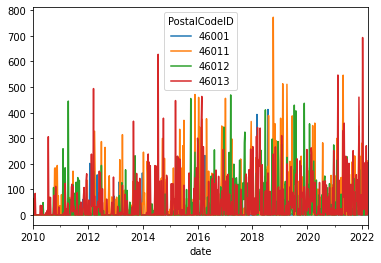

In [ ]:
vol_df_weekly.iloc[:, 1:5].set_index(pd.to_datetime(vol_df_weekly.date), drop=True).plot()
vol_df_weekly

In [ ]:
# merge sales and volume numbers in the same df and compare each zipcode numbers
sales_vol = pd.merge(vol_df.T, sales_df.T, how = "right", on = vol_df.T.index,  suffixes=('_vol', '_sales'))
sales_vol.sum()
sales_vol

PostalCodeID,key_0,46001_vol,46011_vol,46012_vol,46013_vol,46016_vol,46017_vol,46018_vol,46030_vol,46031_vol,...,62423_sales,62428_sales,62440_sales,62441_sales,62442_sales,62447_sales,62468_sales,62469_sales,62474_sales,86705_sales
0,2010-01-01,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-02,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-03,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-04,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-05,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467,2022-03-26,161.0,40.05,0.0,24.94,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,119.99,0.0,0.0,0.0,0.0,0.0,0.0
4468,2022-03-27,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4469,2022-03-28,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4470,2022-03-29,0.0,42.14,0.0,168.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# RETRUNS AND EXCHANGES 
counter = 0
dates = []
z = []
v =[]
s = []

for i in range(len(sales_vol)): 
    for col in vol_df.T.columns:
        if sales_vol[f"{col}_vol"][i] > 0 and sales_vol[f"{col}_sales"][i] <= 0 :
            x = sales_vol["key_0"][sales_vol.index == i]
            # print(i, x.values, col)
            # print(x.values[0])
            counter+=1
            dates.append(x.values[0])
            z.append(col)
            v.append(sales_vol[f"{col}_vol"][i])
            s.append(sales_vol[f"{col}_sales"][i])


# return_exchange_df["Date"] = sales_vol["key_0"][sales_vol.index == i]
# return_exchange_df["zipcode"] = col
        
print(counter)

return_exchange_df = pd.DataFrame({"Date":dates, "zipcode":z, "volume":v, "sales":s})
print(return_exchange_df)

6227
            Date  zipcode  volume   sales
0     2010-01-07    46037    2.06    0.00
1     2010-02-01    46123    0.24    0.00
2     2010-02-11    46203   21.53    0.00
3     2010-02-27    46038   17.00    0.00
4     2010-04-03    46055    9.97    0.00
...          ...      ...     ...     ...
6222  2022-03-29    60026   36.00    0.00
6223  2022-03-30    47803    4.00    0.00
6224  2022-03-30    47805  104.00 -149.99
6225  2022-03-30    60083    3.84 -159.99
6226  2022-03-30    60163   10.43 -270.96

[6227 rows x 4 columns]


In [ ]:
vol_count_df_weekly.to_csv(f"{data_path}/Romeoville/Romeoville_Weekly_Data_Count_Volume.csv")

# Data for Clustering

In [ ]:
def create_single_year_data(data, year):
    count_df_weekly_yby = data.reset_index()
    count_df_weekly_yby = count_df_weekly_yby.rename(columns = {"index":"zipcode"})
    count_df_weekly_yby['zipcode']= pd.to_datetime(count_df_weekly_yby['zipcode'])
    count_df_weekly_single_year = count_df_weekly_yby[count_df_weekly_yby.zipcode.dt.year == year]
    # print(count_df_weekly_single_year)
    return count_df_weekly_single_year

def create_cluster_data(vol_c_data, sales_c_data, vol_n_data, sales_n_data, year): 
    if year == 0:
        vol_weekly_count_avg = vol_c_data.mean()
        sales_weekly_count_avg = sales_c_data.mean()

        vol_weekly_avg = vol_n_data.mean()
        sales_weekly_avg = sales_n_data.mean()

    elif year>=2010 and year <=2022:
        vol_c_data = create_single_year_data(vol_c_data, year)
        sales_c_data = create_single_year_data(sales_c_data, year)
        vol_n_data = create_single_year_data(vol_n_data, year)
        sales_n_data = create_single_year_data(sales_n_data, year)

        vol_weekly_count_avg = vol_c_data.mean()
        sales_weekly_count_avg = sales_c_data.mean()

        vol_weekly_avg = sales_n_data.mean()
        sales_weekly_avg = sales_n_data.mean()


    weekly_avg = pd.DataFrame({f'vol_weekly_count_avg_{year}': vol_weekly_count_avg,f'sales_weekly_count_avg_{year}':sales_weekly_count_avg, f"vol_weekly_avg_{year}":vol_weekly_avg, f"sales_weekly_avg_{year}":sales_weekly_avg})
    weekly_avg.reset_index(inplace = True)
    weekly_avg = weekly_avg.rename({"PostalCodeID":"zipcode"},axis=1)
    # weekly_avg = weekly_avg.drop(weekly_avg.index[weekly_avg["zipcode"]==46438])
    weekly_avg.to_csv(f"/content/drive/MyDrive/geo/data/Romeoville/Romeoville-weekly_averages__{year}.csv")
    print(weekly_avg)
    return weekly_avg


In [ ]:
weekly_averages_0 = create_cluster_data(vol_count_df_weekly, sales_count_df_weekly, vol_df_weekly, sales_df_weekly, 0)
weekly_averages_0.to_csv(f"{data_path}/weekly_averages_data_all_12_years.csv")


      zipcode  vol_weekly_count_avg_0  sales_weekly_count_avg_0  \
0       46001                0.094044                  0.094044   
1       46011                0.641066                  0.633229   
2       46012                0.443574                  0.438871   
3       46013                0.606583                  0.601881   
4       46016                0.221003                  0.219436   
...       ...                     ...                       ...   
1011    62447                0.017241                  0.017241   
1012    62468                0.047022                  0.047022   
1013    62469                0.006270                  0.006270   
1014    62474                0.031348                  0.031348   
1015    86705                0.001567                  0.001567   

      vol_weekly_avg_0  sales_weekly_avg_0  
0             8.042915          112.686505  
1            54.947022          877.646818  
2            34.988229          556.720266  
3            51

In [ ]:
# vol_weekly_count_avg = vol_df_weekly.T.mean()
# sales_weekly_count_avg = sales_df_weekly.T.mean()

# vol_weekly_avg = vol_df.T.mean()
# sales_weekly_avg = sales_df.T.mean()

# weekly_avg = pd.DataFrame({'vol_weekly_count_avg': vol_weekly_count_avg,'sales_weekly_count_avg':sales_weekly_count_avg, "vol_weekly_avg":vol_weekly_avg, "sales_weekly_avg":sales_weekly_avg})
# weekly_avg.reset_index(inplace = True)
# weekly_avg = weekly_avg.rename({"PostalCodeID":"zipcode"},axis=1)
# weekly_avg = weekly_avg.drop(weekly_avg.index[weekly_avg["zipcode"]==46438])
# weekly_avg.to_csv("/content/drive/MyDrive/geo/data/Romeoville/Romeoville-weekly_averages_12_years.csv")

In [ ]:
# zipcode_vol = []
# zipcode_sales = []
# num_days_vol =[]
# sum_vol = []
# num_days_sales =[]
# sum_sales = []

# # Get the count of non-Zeros values in columns 
# for i in vol_df.columns:
# #     print(i)
#     count_vol = (vol_df[i] != 0).sum()
# #     print(count)
#     sum_v = vol_df[i].sum()
# #     print(sum_)
#     sum_vol.append(sum_v)
#     zipcode_vol.append(i)
#     num_days_vol.append(count_vol)
    
#     # print(f'Count of no.n zeros in Column {i} : ', count)

# for i in sales_df.columns:
# #     print(i)
#     count_sales = (sales_df[i] != 0).sum()
# #     print(count)
#     sum_s = sales_df[i].sum()
# #     print(sum_)
#     sum_sales.append(sum_s)
#     zipcode_sales.append(i)
#     num_days_sales.append(count_sales)

# # sum_vol = sum_vol[1:]
# # print(len(num_days), len(zipcode),len(sum_vol))

# delivery_days_vol = pd.DataFrame({'zipcode_vol':zipcode_vol, 'num_days_vol':num_days_vol, 'sum_vol':sum_vol})
# delivery_days_vol = delivery_days_vol.iloc[1:,:]
# delivery_days_vol = delivery_days_vol.sort_values(by='zipcode_vol')
# delivery_days_vol["zipcode_vol"].reset_index(drop = True, inplace = True)
# delivery_days_vol = delivery_days_vol.drop(delivery_days_vol.index[delivery_days_vol["zipcode_vol"]==46438])
# # delivery_days_vol

# delivery_days_sales = pd.DataFrame({'zipcode_sales':zipcode_sales, 'num_days_sales':num_days_sales, 'sum_sales':sum_sales})
# delivery_days_sales = delivery_days_sales.iloc[1:,:]
# delivery_days_sales = delivery_days_sales.sort_values(by='zipcode_sales')
# delivery_days_sales["zipcode_sales"].reset_index(drop = True, inplace = True)
# delivery_days_sales = delivery_days_sales.drop(delivery_days_sales.index[delivery_days_sales["zipcode_sales"]==46438])
# # delivery_days_sales

# # delivery_days[delivery_days["num_zips"] == 4]
# # day = 11
# # selected_days = list(delivery_days["date"][delivery_days["num_zips"] == day])
# # print(selected_days)
# # selected_day = selected_days[0]

# delivery_days_vol.head()
# delivery_days_sales.head()

# zips_no_goe_data = list(set(delivery_days_vol["zipcode"]) - set(zips["zipcode"]))
# print("Number of missing zipcodes:",len(zips_no_goe_data))
# print("Missing zipcodes:",zips_no_goe_data)

In [ ]:
zips_no_goe_data = list(set(weekly_averages_0["zipcode"]) - set(zips["zipcode"]))
print("Number of missing zipcodes:",len(zips_no_goe_data))
print("Missing zipcodes:",zips_no_goe_data)

Number of missing zipcodes: 11
Missing zipcodes: [46211, 46438, 46351, 86705, 60658, 46354, 61009, 60057, 60635, 60092, 60125]


In [ ]:
data = pd.merge(zips, weekly_averages_0,  how="right", on=["zipcode"])
data = data.dropna(subset=['latitude', 'longitude'])
data.to_csv("/content/drive/MyDrive/geo/data/Romeoville/Romeoville-weekly_averages_12_years_with_geo_data.csv")
data

,zipcode,City,County,State,CountyFIPS,StateFIPS,TimeZone,DayLightSavings,latitude,longitude,vol_weekly_count_avg_0,sales_weekly_count_avg_0,vol_weekly_avg_0,sales_weekly_avg_0
0,46001,ALEXANDRIA,MADISON,IN,95.0,18.0,5.0,Y,40.239110,-85.673842,0.094044,0.094044,8.042915,112.686505
1,46011,CTRY CLB HGTS,MADISON,IN,95.0,18.0,5.0,Y,40.113328,-85.767502,0.641066,0.633229,54.947022,877.646818
2,46012,ANDERSON,MADISON,IN,95.0,18.0,5.0,Y,40.154339,-85.625772,0.443574,0.438871,34.988229,556.720266
3,46013,ANDERSON,MADISON,IN,95.0,18.0,5.0,Y,40.050362,-85.686448,0.606583,0.601881,51.993323,798.014514
4,46016,ANDERSON,MADISON,IN,95.0,18.0,5.0,Y,40.101240,-85.672430,0.221003,0.219436,15.731724,253.834154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,62442,MARTINSVILLE,CRAWFORD,IL,33.0,17.0,6.0,Y,39.329173,-87.861873,0.230408,0.227273,17.058636,328.192461
1011,62447,NEOGA,COLES,IL,29.0,17.0,6.0,Y,39.312617,-88.452552,0.017241,0.017241,1.862445,27.831207
1012,62468,TOLEDO,CUMBERLAND,IL,35.0,17.0,6.0,Y,39.273349,-88.275019,0.047022,0.047022,3.723417,55.896426
1013,62469,TRILLA,CUMBERLAND,IL,35.0,17.0,6.0,Y,39.373012,-88.332186,0.006270,0.006270,0.430016,2.389436


# Distance from the Depot

In [ ]:
from geopy import distance
import requests # to call the openmap/google apis
import json
# import datetime
# import math
import itertools

In [ ]:
depot = data[data["zipcode"] == 60446]
depot

,zipcode,City,County,State,CountyFIPS,StateFIPS,TimeZone,DayLightSavings,latitude,longitude,vol_weekly_count_avg_0,sales_weekly_count_avg_0,vol_weekly_avg_0,sales_weekly_avg_0
619,60446,LOCKPORT,WILL,IL,197.0,17.0,6.0,Y,41.636022,-88.095961,3.833856,3.830721,1186.836379,19753.043934


In [ ]:
temp_df = data.copy()
temp_df.index = list(range(0, len(temp_df)))
temp_df

,zipcode,City,County,State,CountyFIPS,StateFIPS,TimeZone,DayLightSavings,latitude,longitude,vol_weekly_count_avg_0,sales_weekly_count_avg_0,vol_weekly_avg_0,sales_weekly_avg_0
0,46001,ALEXANDRIA,MADISON,IN,95.0,18.0,5.0,Y,40.239110,-85.673842,0.094044,0.094044,8.042915,112.686505
1,46011,CTRY CLB HGTS,MADISON,IN,95.0,18.0,5.0,Y,40.113328,-85.767502,0.641066,0.633229,54.947022,877.646818
2,46012,ANDERSON,MADISON,IN,95.0,18.0,5.0,Y,40.154339,-85.625772,0.443574,0.438871,34.988229,556.720266
3,46013,ANDERSON,MADISON,IN,95.0,18.0,5.0,Y,40.050362,-85.686448,0.606583,0.601881,51.993323,798.014514
4,46016,ANDERSON,MADISON,IN,95.0,18.0,5.0,Y,40.101240,-85.672430,0.221003,0.219436,15.731724,253.834154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,62442,MARTINSVILLE,CRAWFORD,IL,33.0,17.0,6.0,Y,39.329173,-87.861873,0.230408,0.227273,17.058636,328.192461
1001,62447,NEOGA,COLES,IL,29.0,17.0,6.0,Y,39.312617,-88.452552,0.017241,0.017241,1.862445,27.831207
1002,62468,TOLEDO,CUMBERLAND,IL,35.0,17.0,6.0,Y,39.273349,-88.275019,0.047022,0.047022,3.723417,55.896426
1003,62469,TRILLA,CUMBERLAND,IL,35.0,17.0,6.0,Y,39.373012,-88.332186,0.006270,0.006270,0.430016,2.389436


In [ ]:
def get_distance(point1: dict, point2: dict) -> tuple:
    """Gets distance between two points en route using http://project-osrm.org/docs/v5.10.0/api/#nearest-service"""
    ''' durations array of arrays that stores the matrix in row-major order. durations[i][j] gives the travel time from the i-th waypoint to the j-th waypoint. 
    Values are given in seconds. Can be null if no route between i and j can be found. '''

    '''distance: The distance, in metres, between each pair of coordinates '''
    url = f"""http://router.project-osrm.org/route/v1/driving/{point1["longitude"]},{point1["latitude"]};{point2["longitude"]},{point2["latitude"]}?overview=false&alternatives=false"""
    r = requests.get(url)
    
    # get the distance from the returned values
    route = json.loads(r.content)["routes"][0]
    return (route["distance"], route["duration"])

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ce_cities = temp_df[["zipcode",'latitude','longitude']]
# get the distance and duration from OSRM API for all our combinations.


dist_array = []
dist_cost = []
dur_cost = []

point1 = {'latitude': 41.636022, 'longitude': -88.095961}
# print(point1)
for j, o in ce_cities.iterrows(): #for j, o in ce_cities[ce_cities.index != i].iterrows():
    point2 = {"latitude": o["latitude"], "longitude": o["longitude"]}
    # print(point2)
    dist, duration = get_distance(point1, point2)
    print(point1,point2,dist, duration)
    # print(dist, duration)
    #dist = geodesic((i_lat, i_lon), (o["CapitalLatitude"], o["CapitalLongitude"])).km
    # dist_array.append(("60446", df.iloc[j,0], duration, dist))
    dist_array.append(("60446", ce_cities.iloc[j,0], duration*0.0166667, dist*0.0006213688756)) #df.iloc[i,0], df.iloc[j,0]  from km to miles and seconds to minutes
    # print(dist_array)
    # dist_cost.append((df.iloc[i,0], df.iloc[j,0], dist*0.000621371)) #df.iloc[i,0], df.iloc[j,0]
    # dur_cost.append((df.iloc[i,0], df.iloc[j,0], duration*0.0166667)) #df.iloc[i,0], df.iloc[j,0]

{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.23911, 'longitude': -85.673842} 331273.5 15970.6
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.113328, 'longitude': -85.767502} 333354.4 15704.1
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.154339, 'longitude': -85.625772} 369142.7 16829.2
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.050362, 'longitude': -85.686448} 358122.2 15784.4
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.10124, 'longitude': -85.67243} 361579.7 16050.6
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.070184, 'longitude': -85.604965} 362147.2 16279.7
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.1056, 'longitude': -85.6805} 339990.4 16052.2
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.1681, 'longitude': -86.023262} 307622.8 14747.4
{'latitude': 41.636022, 'longitude': -88.095961} {'latitude': 40.204871, 'longitude': -86

In [ ]:
dist_dur_df =  pd.DataFrame(dist_array)
col_names = ["depot","to_zipcode","duration_min", "distance_miles"]
dist_dur_df.columns = col_names
dist_dur_df

dist_dur_df.to_csv(f"{data_path}/Romeoville/Romeoville_distance_array.csv")
# comparing to Google Maps duration and distance, these numbers are slightly different.

In [ ]:
dist_dur_df

,depot,to_zipcode,duration_min,distance_miles
0,60446,46001,266.177199,205.843042
1,60446,46011,261.735523,207.136049
2,60446,46012,280.487228,229.373784
3,60446,46013,263.073859,222.525989
4,60446,46016,267.510535,224.674372
...,...,...,...,...
1000,60446,62442,273.238880,213.778917
1001,60446,62447,219.503772,182.768260
1002,60446,62468,235.325471,189.559201
1003,60446,62469,223.292113,179.603194


# Distance_Route_Lat_Lon

In [ ]:
new_data = pd.merge(data, route_codes, on= "zipcode")
new_data.head()

NameError: ignored

In [ ]:
new_data = new_data[["zipcode", "latitude", "longitude", "RouteCodeID"]]
new_data.head()

In [ ]:
dist_dur = dist_dur_df.rename(columns = {"to_zipcode":"zipcode"})
dist_dur = pd.merge(dist_dur, new_data,  on = "zipcode")
dist_dur.to_csv(f"{data_path}/Romeoville_dist_dur_routecode_lat_lon.csv")
dist_dur

In [ ]:
dist_dur[dist_dur["zipcode"]==60446]

# Plot Functions

In [ ]:
def plot_clusters(data_frame, i, j):      
    fig, ax = plt.subplots()

    scatter = ax.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters[f'Clusters_{i}_{j}'],cmap='rainbow')

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.xlim(-92,-83)
    plt.ylim(39,44)
    # produce a legend with a cross section of sizes from the scatter
    # handles, labels = scatter.legend_elements(alpha=0.6)
    # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

    plt.show()


In [ ]:
def plot_clusters_plotly(data_frame, i, j):

    fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color=f'Clusters_{i}_{j}', hover_data=['zipcode'], width=800, height=400) #size ="vol_weekly_avg", 

    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor="LightSteelBlue",
    )

    fig.show()

## plot 12 years averages

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

In [ ]:
plt.scatter(data['longitude'],data['latitude'])
plt.xlim(-150,120)
plt.ylim(-100,100)
plt.show()


In [ ]:
plt.scatter(data['longitude'],data['latitude'],c=data['sales_weekly_count_avg_0'],cmap='rainbow')
plt.xlim(-92,-83)
plt.ylim(39,44)
plt.show()
plt.scatter(data['longitude'],data['latitude'],c=data['sales_weekly_avg_0'],cmap='rainbow')
plt.xlim(-92,-83)
plt.ylim(39,44)
plt.show()

In [ ]:
plt.scatter(data['longitude'],data['latitude'],c=data['vol_weekly_count_avg_0'],cmap='rainbow')
plt.xlim(-92,-83)
plt.ylim(39,44)
plt.show()
plt.scatter(data['longitude'],data['latitude'],c=data['vol_weekly_avg_0'],cmap='rainbow')
plt.xlim(-92,-83)
plt.ylim(39,44)
plt.show()

## Clustering counts of delivery avg for 12 years

In [ ]:
X = data.iloc[:,[0,8,9,10,11,12,13]]
X

In [ ]:
# X = X[X['latitude'].notna()]
X.isna().sum()

In [ ]:
X

In [ ]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['latitude']]
X_axis = X[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
# ONLY CONSIDERS Lat and Lon
kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis', figsize=(15,15))
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=200, alpha=0.5)

# CLUSTERING with ALL 12 YEARS DATA

### Clustering based on count

In [ ]:
count_clusters = data[['zipcode', 'vol_weekly_count_avg_0', 'sales_weekly_count_avg_0']]
count_clusters

In [ ]:
# CONSIDERS ZIPCODE AND VOLUME DELIVERY COUNTS
# x = data[['longitude','latitude', 'num_days', 'sum_vol']] 
x = data[['vol_weekly_count_avg_0', 'sales_weekly_count_avg_0']]  #'longitude','latitude'
# x = x.iloc[:-1,:]
x

In [ ]:
# Within-Cluster Sum of Square. WCSS is the sum of squared distance between each point and the centroid in a cluster. 
wcss=[]
for i in range(1,20):
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,20)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#  elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,}

# A list holds the SSE values for each k - sum of square error
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=42)
kmeans.fit(x)

identified_clusters = kmeans.fit_predict(x)
identified_clusters

data_with_clusters = data.copy()
data_with_clusters['Clusters'] = identified_clusters 

In [ ]:
# data_with_clusters

In [ ]:
import plotly.express as px

fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color="Clusters",  hover_data=['zipcode']) #size ="vol_weekly_avg", 
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

In [ ]:
fig, ax = plt.subplots()

scatter = ax.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.xlim(-92,-83)
plt.ylim(39,44)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

In [ ]:
# plt.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')
# plt.xlim(-92,-83)
# plt.ylim(39,44)
# plt.show()

In [ ]:
#  The lowest sum of the squared error (SSE) value
kmeans.inertia_

In [ ]:
# Final locations of the centroid
kmeans.cluster_centers_

In [ ]:
# The number of iterations required to converge
kmeans.n_iter_

In [ ]:
kmeans.labels_

## 2, 3, 4, and 5 clusters - 12 years count data



In [ ]:
for i in range(2,6):
    kmeans = KMeans(
        init="random",
        n_clusters=i,
        n_init=10,
        max_iter=300,
        random_state=42)
    kmeans.fit(x)

    identified_clusters = kmeans.fit_predict(x)
    identified_clusters

    data_with_clusters = data.copy()
    data_with_clusters['Clusters'] = identified_clusters     
    fig, ax = plt.subplots()

    scatter = ax.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.xlim(-92,-83)
    plt.ylim(39,44)
    # produce a legend with a cross section of sizes from the scatter
    # handles, labels = scatter.legend_elements(alpha=0.6)
    # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

    plt.show()

    count_clusters[f"{i}_clusters"] = kmeans.labels_
    count_clusters
    unique, counts = np.unique(identified_clusters, return_counts=True)
    print(np.column_stack((unique, counts)))
    print(count_clusters)

In [ ]:
import plotly.express as px

for i in range(2,6):
    kmeans = KMeans(
        init="random",
        n_clusters=i,
        n_init=10,
        max_iter=300,
        random_state=42)
    kmeans.fit(x)

    identified_clusters = kmeans.fit_predict(x)
    identified_clusters

    data_with_clusters = data.copy()
    data_with_clusters['Clusters'] = identified_clusters     

    fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color="Clusters", hover_data=['zipcode'], width=800, height=400) #size ="vol_weekly_avg", 
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor="LightSteelBlue",
    )

    fig.show()

    count_clusters[f"{i}_cluster"] = kmeans.labels_
    count_clusters
    unique, counts = np.unique(identified_clusters, return_counts=True)
    print(np.column_stack((unique, counts)))
    print(count_clusters)

In [ ]:
count_clusters

In [ ]:
print( "#################### BASED ON 12 YEARS AVERAGES  (vol and sales count) ####################")
for i in range(2,6):
    print("|-----------------------------------------------------------------------------------------|")
    print(f"| Total number of clusters:| {i}                                                            |")
    print("|-----------------------------------------------------------------------------------------|")
    print(f"| Cluster label| min(vol_count) |   max(vol_count)   | min(sales_count) | max(sales_count)|")
    print("|--------------|----------------|--------------------|-----------------|------------------|")
    for j in range(0, i):
        min_vol = format(count_clusters["vol_weekly_count_avg_0"][count_clusters[f"{i}_clusters"]==j].min(),".4f")
        max_vol = format(count_clusters["vol_weekly_count_avg_0"][count_clusters[f"{i}_clusters"]==j].max(),".4f")
        min_sales = format(count_clusters["sales_weekly_count_avg_0"][count_clusters[f"{i}_clusters"]==j].min(),".4f")
        max_sales = format(count_clusters["sales_weekly_count_avg_0"][count_clusters[f"{i}_clusters"]==j].max(),".4f")
        print("|     ", j, "      |    ", min_vol , "    |     ", max_vol, "       |    ", min_sales, "     |     ",  max_sales ,"     |")
        print("|--------------|----------------|--------------------|-----------------|------------------|")
    print()

## 2,3,4, and 5 clusters for sales and volume numbers - 12 years

In [ ]:
number_clusters = data[['zipcode', 'vol_weekly_avg_0', 'sales_weekly_avg_0']]
number_clusters

In [ ]:
# x = data[['longitude','latitude', 'num_days', 'sum_vol']] 
y = data[['vol_weekly_avg_0', 'sales_weekly_avg_0']]  #'longitude','latitude'

In [ ]:
for i in range(2,6):
    kmeans = KMeans(
        init="random",
        n_clusters=i,
        n_init=10,
        max_iter=300,
        random_state=42)
    kmeans.fit(y)

    identified_clusters = kmeans.fit_predict(y)
    identified_clusters

    data_with_clusters = data.copy()
    data_with_clusters['Clusters'] = identified_clusters     
    fig, ax = plt.subplots()

    scatter = ax.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.xlim(-92,-83)
    plt.ylim(39,44)
    # produce a legend with a cross section of sizes from the scatter
    # handles, labels = scatter.legend_elements(alpha=0.6)
    # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

    plt.show()

    number_clusters[f"{i}_clusters"] = kmeans.labels_
    number_clusters
    unique, counts = np.unique(identified_clusters, return_counts=True)
    print(np.column_stack((unique, counts)))
    print(number_clusters)

In [ ]:
number_clusters

In [ ]:
print("    ############################ BASED ON 12 YEARS AVERAGES  (vol and sales numbers) ############################")
for i in range(2,6):
    print("|-----------------------------------------------------------------------------------------|")
    print(f"| Total number of clusters:| {i}                                                            |")
    print("|-----------------------------------------------------------------------------------------|")
    print(f"| Cluster label   | min(vol_count) |   max(vol_count)   | min(sales_count) | max(sales_count)|")
    print("|-----------------|----------------|--------------------|-----------------|------------------|")
    for j in range(0, i):
        min_vol = format(number_clusters["vol_weekly_avg_0"][number_clusters[f"{i}_clusters"]==j].min(),".4f")
        max_vol = format(number_clusters["vol_weekly_avg_0"][number_clusters[f"{i}_clusters"]==j].max(),".4f")
        min_sales = format(number_clusters["sales_weekly_avg_0"][number_clusters[f"{i}_clusters"]==j].min(),".4f")
        max_sales = format(number_clusters["sales_weekly_avg_0"][number_clusters[f"{i}_clusters"]==j].max(),".4f")
        print("|     ", j, "         |  ", min_vol , "      |     ", max_vol, "       |    ", min_sales, "     |     ",  max_sales ,"     |")
        print("|-----------------|----------------|--------------------|-----------------|------------------|")
    print()

In [ ]:
import plotly.express as px

for i in range(2,6):
    kmeans = KMeans(
        init="random",
        n_clusters=i,
        n_init=10,
        max_iter=300,
        random_state=42)
    kmeans.fit(y)

    identified_clusters = kmeans.fit_predict(y)
    identified_clusters

    data_with_clusters = data.copy()
    data_with_clusters['Clusters'] = identified_clusters     

    fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color="Clusters", hover_data=['zipcode'], width=800, height=400) #size ="vol_weekly_avg", 
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor="LightSteelBlue",
    )

    fig.show()

    number_clusters[f"{i}_cluster"] = kmeans.labels_
    number_clusters
    unique, counts = np.unique(identified_clusters, return_counts=True)
    print(np.column_stack((unique, counts)))
    print(number_clusters)

In [ ]:
# for i in range(1,10):
#     kmeans = KMeans(
#         init="random",
#         n_clusters=i,
#         n_init=10,
#         max_iter=300,
#         random_state=42)
#     kmeans.fit(x)

#     identified_clusters = kmeans.fit_predict(x)
#     identified_clusters

#     data_with_clusters = data.copy()
#     data_with_clusters['Clusters'] = identified_clusters 
#     plt.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')
#     plt.xlim(-92,-83)
#     plt.ylim(39,44)

#     plt.show()


#     weekly_avg[f"{i}_cluster"] = kmeans.labels_
#     weekly_avg
#     unique, counts = np.unique(identified_clusters, return_counts=True)
#     print(np.column_stack((unique, counts)))
#     print(weekly_avg)

# # CLUSTERING with ALL DATA Year by Year

In [ ]:
vol_df, vol_count_df = load_data(vol_path)
sales_df, sales_count_df =load_data(sales_path)


# converting list to DataFrame object
vol_count_df_weekly = pd.DataFrame(new_case_count(vol_count_df))
sales_count_df_weekly = pd.DataFrame(new_case_count(sales_count_df))

vol_count_df_weekly.head(), sales_count_df_weekly.head()



In [ ]:
# converting list to DataFrame object
vol_df_weekly = pd.DataFrame(new_case_count(vol_df))
sales_df_weekly = pd.DataFrame(new_case_count(sales_df))

vol_df_weekly, sales_df_weekly

In [ ]:
def create_single_year_data(data, year):
    count_df_weekly_yby = data.reset_index()
    count_df_weekly_yby = count_df_weekly_yby.rename(columns = {"index":"zipcode"})
    count_df_weekly_yby['zipcode']= pd.to_datetime(count_df_weekly_yby['zipcode'])
    count_df_weekly_single_year = count_df_weekly_yby[count_df_weekly_yby.zipcode.dt.year == year]
    # print(count_df_weekly_single_year)
    return count_df_weekly_single_year

def create_cluster_data(vol_c_data, sales_c_data, vol_n_data, sales_n_data, year): 
    if year == 0:
        vol_weekly_count_avg = vol_c_data.mean()
        sales_weekly_count_avg = sales_c_data.mean()

        vol_weekly_avg = vol_n_data.mean()
        sales_weekly_avg = sales_n_data.mean()

    elif year>=2010 and year <=2022:
        vol_c_data = create_single_year_data(vol_c_data, year)
        sales_c_data = create_single_year_data(sales_c_data, year)
        vol_n_data = create_single_year_data(vol_n_data, year)
        sales_n_data = create_single_year_data(sales_n_data, year)

        vol_weekly_count_avg = vol_c_data.mean()
        sales_weekly_count_avg = sales_c_data.mean()

        vol_weekly_avg = vol_n_data.mean()
        sales_weekly_avg = sales_n_data.mean()


    weekly_avg = pd.DataFrame({f'vol_weekly_count_avg_{year}': vol_weekly_count_avg,f'sales_weekly_count_avg_{year}':sales_weekly_count_avg, f"vol_weekly_avg_{year}":vol_weekly_avg, f"sales_weekly_avg_{year}":sales_weekly_avg})
    weekly_avg.reset_index(inplace = True)
    weekly_avg = weekly_avg.rename({"PostalCodeID":"zipcode"},axis=1)
    # weekly_avg = weekly_avg.drop(weekly_avg.index[weekly_avg["zipcode"]==46438])
    weekly_avg.to_csv(f"/content/drive/MyDrive/geo/data/Romeoville/Romeoville-weekly_averages__{year}.csv")
    print(weekly_avg)
    return weekly_avg


In [ ]:
weekly_avg_year_by_year = pd.DataFrame(data=data["zipcode"])
for year in range(2010, 2023):
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%",year, "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    weekly_averages_single_year = create_cluster_data(vol_count_df_weekly, sales_count_df_weekly, vol_df_weekly, sales_df_weekly, year)
    weekly_averages_single_year
    # weekly_averages_year = weekly_averages_year.drop(weekly_averages_year.index[weekly_averages_year["zipcode"].isin(zips_to_drop)])
    print(weekly_averages_single_year)

    weekly_avg_year_by_year = pd.merge(weekly_avg_year_by_year, weekly_averages_single_year, on  = "zipcode")


In [ ]:
weekly_avg_year_by_year

In [ ]:
# weekly_avg_temp = pd.DataFrame(weekly_avg["zipcode"])
# for i in range(2010, 2023):
    
#     vol_df_weekly2 = vol_df_weekly.reset_index()
#     vol_df_weekly2 = vol_df_weekly2.rename(columns={"index":"zipcode"})
#     vol_df_weekly2['zipcode']= pd.to_datetime(vol_df_weekly2['zipcode'])
#     vol_df_weekly_temp = vol_df_weekly2[vol_df_weekly2.zipcode.dt.year == i]
#     vol_weekly_avg_temp = vol_df_weekly_temp.mean()
#     vol_weekly_avg_temp = pd.DataFrame(vol_weekly_avg_temp)
#     vol_weekly_avg_temp.reset_index(inplace = True)
#     # print(vol_weekly_avg_temp)

#     sales_df_weekly2 = sales_df_weekly.reset_index()
#     sales_df_weekly2 = sales_df_weekly2.rename(columns={"index":"zipcode"})
#     sales_df_weekly2['zipcode']= pd.to_datetime(sales_df_weekly2['zipcode'])
#     sales_df_weekly_temp = sales_df_weekly2[sales_df_weekly2.zipcode.dt.year == i]
#     sales_weekly_avg_temp = sales_df_weekly_temp.mean()
#     sales_weekly_avg_temp = pd.DataFrame(sales_weekly_avg_temp)
#     sales_weekly_avg_temp.reset_index(inplace = True)
#     # print(sales_weekly_avg_temp)

#     weekly_avg_temp[f'vol_weekly_avg_{i}'] = vol_weekly_avg_temp.iloc[:,1]
#     weekly_avg_temp[f'sales_weekly_avg_{i}'] = sales_weekly_avg_temp.iloc[:,1]
#     # weekly_avg_temp.reset_index(inplace = True)
#     weekly_avg_temp = weekly_avg_temp.rename({"PostalCodeID":"zipcode"},axis=1)
#     weekly_avg_temp = weekly_avg_temp.drop(weekly_avg_temp.index[weekly_avg_temp["zipcode"]==46438])
#     # print(weekly_avg_temp)

# weekly_avg_year = weekly_avg_temp.copy()

In [ ]:
all_count_clusters_year = weekly_avg_year_by_year['zipcode']
all_count_clusters_year

In [ ]:
weekly_avg_year_by_year

### Clustering based on count year by year

In [ ]:
for i in range(2010, 2013):
    count_clusters_year = weekly_avg_year_by_year[['zipcode', f'vol_weekly_count_avg_{i}', f'sales_weekly_count_avg_{i}']]
    z = weekly_avg_year_by_year[[f'vol_weekly_count_avg_{i}', f'sales_weekly_count_avg_{i}']]
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(count_clusters_year)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

    for j in range(2,6):
        kmeans = KMeans(
            init="random",
            n_clusters = j,
            n_init=10,
            max_iter=300,
            random_state=42)
        kmeans.fit(z)

        identified_clusters = kmeans.fit_predict(z)
        identified_clusters

        data_with_clusters = data[['zipcode','longitude', 'latitude']].copy()
        data_with_clusters[f'Clusters_{i}_{j}'] = identified_clusters     
        fig, ax = plt.subplots()

        scatter = ax.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters[f'Clusters_{i}_{j}'],cmap='rainbow')

        # produce a legend with the unique colors from the scatter
        legend1 = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend1)
        plt.xlim(-92,-83)
        plt.ylim(39,44)
        # produce a legend with a cross section of sizes from the scatter
        # handles, labels = scatter.legend_elements(alpha=0.6)
        # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

        plt.show()

        count_clusters_year[f"{i}_{j}_clusters"] = kmeans.labels_
        count_clusters_year
        unique, counts = np.unique(identified_clusters, return_counts=True)
        print(np.column_stack((unique, counts)))
        print(count_clusters_year)
        all_count_clusters_year = pd.merge(all_count_clusters_year, count_clusters_year, on  = "zipcode")

     
        print( "#################### BASED ON count AVERAGES FOR EACH YEAR (vol and sales count) ####################")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Year:| {i}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Total number of clusters:| {j}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Cluster label| min(vol_count) |   max(vol_count)   | min(sales_count) | max(sales_count)|")
        print("|--------------|----------------|--------------------|-----------------|------------------|")
        
        for n in range(0, j):
            min_vol = format(count_clusters_year[f"vol_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_vol = format(count_clusters_year[f"vol_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            min_sales = format(count_clusters_year[f"sales_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_sales = format(count_clusters_year[f"sales_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            print("|     ", n , "      |    ", min_vol , "    |     ", max_vol, "       |    ", min_sales, "     |     ",  max_sales ,"     |")
            print("|--------------|----------------|--------------------|-----------------|------------------|")
            print()

In [ ]:
all_count_clusters_year

In [ ]:
for i in range(2010, 2013):
    count_clusters_year = weekly_avg_year_by_year[['zipcode', f'vol_weekly_count_avg_{i}', f'sales_weekly_count_avg_{i}']]
    z = weekly_avg_year_by_year[[f'vol_weekly_count_avg_{i}', f'sales_weekly_count_avg_{i}']]
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(count_clusters_year)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

    for j in range(2,6):
        kmeans = KMeans(
            init="random",
            n_clusters = j,
            n_init=10,
            max_iter=300,
            random_state=42)
        kmeans.fit(z)

        identified_clusters = kmeans.fit_predict(z)
        identified_clusters

        data_with_clusters = data[['zipcode','longitude', 'latitude']].copy()
        data_with_clusters[f'Clusters_{i}_{j}'] = identified_clusters 


        fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color=f'Clusters_{i}_{j}', hover_data=['zipcode'], width=800, height=400) #size ="vol_weekly_avg", 
        fig.update_layout(
            autosize=False,
            width=800,
            height=800,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4
            ),
            paper_bgcolor="LightSteelBlue",
        )

        fig.show()


        count_clusters_year[f"{i}_{j}_clusters"] = kmeans.labels_
        count_clusters_year
        unique, counts = np.unique(identified_clusters, return_counts=True)
        print(np.column_stack((unique, counts)))
        print(count_clusters_year)
        all_count_clusters_year = pd.merge(all_count_clusters_year, count_clusters_year, on  = "zipcode")

     
        print( "#################### BASED ON count AVERAGES FOR EACH YEAR (vol and sales count) ####################")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Year:| {i}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Total number of clusters:| {j}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Cluster label| min(vol_count) |   max(vol_count)   | min(sales_count) | max(sales_count)|")
        print("|--------------|----------------|--------------------|-----------------|------------------|")
        
        for n in range(0, j):
            min_vol = format(count_clusters_year[f"vol_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_vol = format(count_clusters_year[f"vol_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            min_sales = format(count_clusters_year[f"sales_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_sales = format(count_clusters_year[f"sales_weekly_count_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            print("|     ", n , "      |    ", min_vol , "    |     ", max_vol, "       |    ", min_sales, "     |     ",  max_sales ,"     |")
            print("|--------------|----------------|--------------------|-----------------|------------------|")
            print()

In [ ]:
# weekly_avg_year_by_year = pd.DataFrame(data=data["zipcode"])
# for i in range(2010, 2023):
#     weekly_averages_year = create_cluster_data(vol_count_df_weekly, sales_count_df_weekly, i)
#     print(weekly_averages_year)
#     weekly_avg_year_by_year = pd.merge(weekly_avg_year_by_year, weekly_averages_year, on  = "zipcode")

In [ ]:
# import plotly.express as px

# for i in range(2,6):
#     kmeans = KMeans(
#         init="random",
#         n_clusters=i,
#         n_init=10,
#         random_state=42)
#     kmeans.fit(z)

#     identified_clusters = kmeans.fit_predict(z)
#     identified_clusters

#     data_with_clusters = data.copy()
#     data_with_clusters['Clusters'] = identified_clusters     

#     fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color="Clusters", hover_data=['zipcode'], width=800, height=400) #size ="vol_weekly_avg", 
#     fig.update_layout(
#         autosize=False,
#         width=800,
#         height=800,
#         margin=dict(
#             l=50,
#             r=50,
#             b=100,
#             t=100,
#             pad=4
#         ),
#         paper_bgcolor="LightSteelBlue",
#     )

#     fig.show()

#     count_clusters[f"{i}_cluster"] = kmeans.labels_
#     count_clusters
#     unique, counts = np.unique(identified_clusters, return_counts=True)
#     print(np.column_stack((unique, counts)))
#     print(count_clusters)

### Clustering based on numbers year by year

In [ ]:
for i in range(2010, 2023):
    count_clusters_year = weekly_avg_year_by_year[['zipcode', f'vol_weekly_avg_{i}', f'sales_weekly_avg_{i}']]
    z = weekly_avg_year_by_year[[f'vol_weekly_avg_{i}', f'sales_weekly_avg_{i}']]
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(count_clusters_year)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

    for j in range(2,6):
        kmeans = KMeans(
            init="random",
            n_clusters = j,
            n_init=10,
            max_iter=300,
            random_state=42)
        kmeans.fit(z)

        identified_clusters = kmeans.fit_predict(z)
        identified_clusters

        data_with_clusters = data[['zipcode','longitude', 'latitude']].copy()
        data_with_clusters[f'Clusters_{i}_{j}'] = identified_clusters     
        fig, ax = plt.subplots()

        scatter = ax.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters[f'Clusters_{i}_{j}'],cmap='rainbow')

        # produce a legend with the unique colors from the scatter
        legend1 = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend1)
        plt.xlim(-92,-83)
        plt.ylim(39,44)
        # produce a legend with a cross section of sizes from the scatter
        # handles, labels = scatter.legend_elements(alpha=0.6)
        # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

        plt.show()

        count_clusters_year[f"{i}_{j}_clusters"] = kmeans.labels_
        count_clusters_year
        unique, counts = np.unique(identified_clusters, return_counts=True)
        print(np.column_stack((unique, counts)))
        print(count_clusters_year)
        all_count_clusters_year = pd.merge(all_count_clusters_year, count_clusters_year, on  = "zipcode")

     
        print( "#################### BASED ON count AVERAGES FOR EACH YEAR (vol and sales count) ####################")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Year:| {i}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Total number of clusters:| {j}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Cluster label| min(vol_num) |   max(vol_num)   | min(sales_num) | max(sales_num)|")
        print("|--------------|----------------|--------------------|-----------------|------------------|")
        
        for n in range(0, j):
            min_vol = format(count_clusters_year[f"vol_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_vol = format(count_clusters_year[f"vol_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            min_sales = format(count_clusters_year[f"sales_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_sales = format(count_clusters_year[f"sales_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            print("|     ", n , "      |    ", min_vol , "    |     ", max_vol, "       |    ", min_sales, "     |     ",  max_sales ,"     |")
            print("|--------------|----------------|--------------------|-----------------|------------------|")
            print()

In [ ]:
all_count_clusters_year

In [ ]:
for i in range(2010, 2023):
    count_clusters_year = weekly_avg_year_by_year[['zipcode', f'vol_weekly_avg_{i}', f'sales_weekly_avg_{i}']]
    z = weekly_avg_year_by_year[[f'vol_weekly_avg_{i}', f'sales_weekly_avg_{i}']]
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(count_clusters_year)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

    for j in range(2,6):
        kmeans = KMeans(
            init="random",
            n_clusters = j,
            n_init=10,
            max_iter=300,
            random_state=42)
        kmeans.fit(z)

        identified_clusters = kmeans.fit_predict(z)
        identified_clusters

        data_with_clusters = data[['zipcode','longitude', 'latitude']].copy()
        data_with_clusters[f'Clusters_{i}_{j}'] = identified_clusters 


        fig = px.scatter(data_with_clusters, x='longitude', y="latitude", color=f'Clusters_{i}_{j}', hover_data=['zipcode'], width=800, height=400) #size ="vol_weekly_avg", 
        fig.update_layout(
            autosize=False,
            width=800,
            height=800,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4
            ),
            paper_bgcolor="LightSteelBlue",
        )

        fig.show()


        count_clusters_year[f"{i}_{j}_clusters"] = kmeans.labels_
        count_clusters_year
        unique, counts = np.unique(identified_clusters, return_counts=True)
        print(np.column_stack((unique, counts)))
        print(count_clusters_year)
        all_count_clusters_year = pd.merge(all_count_clusters_year, count_clusters_year, on  = "zipcode")

     
        print( "#################### BASED ON AVERAGES FOR EACH YEAR (vol and sales numbers) ####################")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Year:| {i}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Total number of clusters:| {j}                                                            |")
        print("|-----------------------------------------------------------------------------------------|")
        print(f"| Cluster label| min(vol_num) |   max(vol_num)   | min(sales_num) | max(sales_num)|")
        print("|--------------|----------------|--------------------|-----------------|------------------|")
        
        for n in range(0, j):
            min_vol = format(count_clusters_year[f"vol_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_vol = format(count_clusters_year[f"vol_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            min_sales = format(count_clusters_year[f"sales_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].min(),".4f")
            max_sales = format(count_clusters_year[f"sales_weekly_avg_{i}"][count_clusters_year[f"{i}_{j}_clusters"] == n].max(),".4f")
            print("|     ", n , "      |    ", min_vol , "    |     ", max_vol, "       |    ", min_sales, "     |     ",  max_sales ,"     |")
            print("|--------------|----------------|--------------------|-----------------|------------------|")
            print()

## COMPARISON OF THE CURRENT ROUTES AND CLUSTERS

In [ ]:
route_codes = pd.read_excel(f"{data_path}/Romeoville/Romeoville_route_codes_Postal Codes.xlsx")
route_codes = route_codes.rename(columns={"PostalCodeID": "zipcode"})
route_codes

In [ ]:
route07 = route_codes[route_codes["RouteCodeID"] == "ROM07"]
route01 = route_codes[route_codes["RouteCodeID"] == "ROM01"]
route07["State"].unique(), route01["State"].unique()

In [ ]:
route07["zipcode"].unique()

# Avg distance by clusters

In [ ]:
dist_dur = pd.read_csv(f"{data_path}/Romeoville_dist_dur_routecode_lat_lon.csv")

In [ ]:
dist_dur

## ### EVALUATION

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
# A list holds the Silhouette Coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x)
    score = silhouette_score(x, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Evaluating Clustering Performance Using Advanced Techniques

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [ ]:
scaler = StandardScaler()

In [ ]:
features, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42)
scaled_features = scaler.fit_transform(features)

In [ ]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round (2)

In [ ]:
kmeans_silhouette, dbscan_silhouette #A higher silhouette coefficient suggests better clusters

### Adjusted rand index (ARI):

Unlike the silhouette coefficient, the ARI uses true cluster assignments to measure the similarity between true and predicted labels.

The ARI output values range between -1 and 1. A score close to 0.0 indicates random assignments, and a score close to 1 indicates perfectly labeled clusters.

In [ ]:
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)

round(ari_kmeans, 2), round(ari_dbscan, 2)